# Getting Started with PySpark

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf

In [2]:
# set some spark conf
spark_conf = SparkConf() \
    .setAppName("anomaly_modelling") \
    .set("spark.driver.memory", "12g") \
    .setMaster('local[*]')

In [3]:
#sc.stop()

In [4]:
sc = SparkContext(conf = spark_conf)

In [5]:
# get our sparksession
from pyspark.sql import SparkSession
spark = SparkSession(sc).builder.getOrCreate()#.config("spark.driver.cores", "4")

In [6]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'anomaly_modelling'),
 ('spark.driver.memory', '12g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '34943'),
 ('spark.driver.host', '346169229b3a'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1604803385280')]

## Load My Test file

In [7]:
txt = spark.read.parquet('data/*')
print(txt.count())

13758561


In [8]:
txt.select("key", "totaltime", "objectsize").describe().show()

+-------+------------+------------------+--------------------+
|summary|         key|         totaltime|          objectsize|
+-------+------------+------------------+--------------------+
|  count|    13758561|          13638028|            12791918|
|   mean|        null|27.549267460075605|  1516564.8832174346|
| stddev|        null| 65.15363121886377|1.4335017325813163E7|
|    min|           -|                 1|                   0|
|    max|prefix/dummy|             29596|          2118650593|
+-------+------------+------------------+--------------------+



## Do Some Processing

Some things that we will have to get comfortable with include:
- Managing driver RAM
- How to work with stuff that doesn't all fit in driver RAM / executor RAM
- using Python libs in this situation

In [44]:
import seaborn as sns
%matplotlib inline

In [46]:
from scipy.stats import beta

In [40]:
totaltime_object = txt.select("totaltime").take(500000)

totaltime object is a DataFrame object which numpy and scipy cannot deal with so we need to convert it first. Taking the full object is also too big for us to fit into the driver RAM

In [48]:
#sns.histplot(totaltime_object)

In [49]:
import numpy as np 

In [72]:
totaltime_np = np.array(totaltime_object).flatten()
#totaltime_np = totaltime_np[~np.isnan(totaltime_np)]

11

In [73]:
totaltime_np[0:10]

array([11, 8, 18, 10, 50, 10, 93, 17, 9, 20], dtype=object)

Note that we needed to convert to float in order fo the fitting to be done properly

In [76]:
a1, b1, loc1, scale1 = beta.fit(np.array(totaltime_np[0:10], dtype=float))

Now we can sample values

In [79]:
r = beta.rvs(a1, b1, loc1, scale1, size=1000)

lets check how this looks

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

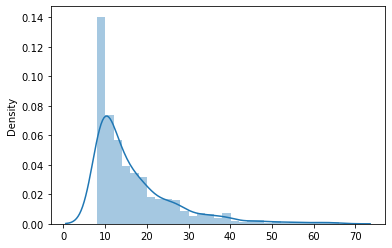

In [80]:
sns.distplot(r)

# Extract the AWS Prefix

we need to extract and analyse data by the AWS Prefix

In [49]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [70]:
def get_object(s):
    splitted = s.split("/")
    return splitted[-1]

getobject_udf = udf(get_object, StringType())

def get_prefix(s):
    splitted = s.split("/")
    prefix = "/".join(splitted[0:-1])
    return prefix

getprefix_udf = udf(get_prefix, StringType())

In [81]:
txt.select("key", getobject_udf("key").alias("object"), getprefix_udf("key").alias("prefix")).take(3)

[Row(key='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2/part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000', object='part-00123-8a3ee488-8530-4fb8-8800-e2ea24335fb2.c000', prefix='dmp/rawcleansed/edh_mcoe_hana/afko/partition%253D2'),
 Row(key='dmp/edh_fs_config/internal/compactionrunlog_dim/part-00000-33c61448-c1cf-4618-aebf-26e88844d6e2-c000', object='part-00000-33c61448-c1cf-4618-aebf-26e88844d6e2-c000', prefix='dmp/edh_fs_config/internal/compactionrunlog_dim'),
 Row(key='dmp/rawcleansed/edh_mcoe_hana/iflotx/partition%253D1/part-00010-8640b6e7-2068-442e-84c3-5ae6b8f8adf8.c000', object='part-00010-8640b6e7-2068-442e-84c3-5ae6b8f8adf8.c000', prefix='dmp/rawcleansed/edh_mcoe_hana/iflotx/partition%253D1')]

In [82]:
txt.columns

['bucketowner',
 'bucket',
 'requestdatetime',
 'remoteip',
 'requester',
 'requestid',
 'operation',
 'key',
 'request',
 'httpstatus',
 'errorcode',
 'bytessent',
 'objectsize',
 'totaltime',
 'turnaroundtime',
 'referrer',
 'useragent',
 'versionid',
 'hostid',
 'sigv',
 'ciphersuite',
 'authtype',
 'endpoint',
 'tlsversion',
 'requesturi_operation',
 'requesturi_key',
 'requesturi_httpprotoversion',
 'requesttimestamp']

In [83]:
txt2 = txt.select("requesttimestamp", "operation", "turnaroundtime", "totaltime", \
                  "objectsize", "bytessent", getobject_udf("key").alias("object"), \
                  getprefix_udf("key").alias("prefix"))

# Grouping by Time Windows

we need to use table windowing functions in order to be able to calculate time based metrics

In [84]:
# 5 tumbling minute intervals
txt2 \
  .groupBy(window("requesttimestamp", "5 minute")) \
  .count().take(3)

[Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 35), end=datetime.datetime(2020, 6, 13, 4, 40)), count=805112),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 50), end=datetime.datetime(2020, 6, 13, 4, 55)), count=1516816),
 Row(window=Row(start=datetime.datetime(2020, 6, 13, 4, 40), end=datetime.datetime(2020, 6, 13, 4, 45)), count=1010694)]

In [88]:
# advanced windows - doesn't seem like we need for now
from pyspark.sql import Window
# this is a window spec and seems to only support explicitly specifying how many rows before 
# and after each you you want
advanced_window = Window.partitionBy("prefix").orderBy("requesttimestamp")

# tumbling windows
txt2 \
  .repartition("prefix") \
  .groupBy("prefix", window("requesttimestamp", windowDuration="5 minute", slideDuration="1 minute")) \
  .count().take(3)

[Row(prefix='dmp/rawcleansed/rc_aurizon_bma/internal/wheelbearingtemp_bogie_av/structured/wheelbearingtemp_bogie_av.parquet/.hive-staging_hive_2020-06-12_23-29-23_137_5376946569663904819-1/-ext-10000/_temporary/0/_temporary/attempt_20200612232933_0105_m_000004_0/part_key%253D2020164', window=Row(start=datetime.datetime(2020, 6, 13, 4, 26), end=datetime.datetime(2020, 6, 13, 4, 31)), count=6),
 Row(prefix='dmp/rawcleansed/rc_aurizon_bma/internal/wheelbearingtemp_train_av/structured/wheelbearingtemp_train_av.parquet/part_key%253D2020140', window=Row(start=datetime.datetime(2020, 6, 13, 4, 27), end=datetime.datetime(2020, 6, 13, 4, 32)), count=270),
 Row(prefix='dmp/rawcleansed/rc_blastlogic_crm/internal/hole_av/structured', window=Row(start=datetime.datetime(2020, 6, 13, 4, 59), end=datetime.datetime(2020, 6, 13, 5, 4)), count=10)]

## Next Actions
- So given that we need to work with datasets that we cannot fit to RAM, how can we best run this job to get a "definitive" sample. - Probably don't need this Actually